Import packages

In [2]:
import re
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

pd.set_option('display.max_colwidth', None)
pd.set_option('display.expand_frame_repr', False)

Set global variables

In [3]:
OUTPUT_PATH = '../data/output/'

Read output data

In [4]:
output_df = pd.read_csv(OUTPUT_PATH + 'output_time_series.csv', index_col=0)

Prepare class for Assets

In [5]:
class Assets:
    """Class for evaluating asset output data."""

    def __init__(self, input_data: pd.DataFrame) -> None:
        self.ids = []
        self.input_data = input_data
        self.asset_data = {}
        self.postprocess_data = {}
        self.objective_value = None

        self.get_asset_ids()
        self.get_asset_data()
        self.calc_postprocess_data()
        self.get_objective_value_from_log()


    def get_asset_ids(self):
        """Get all unique asset names from the input data."""
        ids_set = set()

        for column_name in self.input_data.columns:
            if not '.' in column_name:
                continue
            key = re.sub('\..*$', '', column_name)      # Replace every character after a '.'.
            key = key.replace('_expanded', '')          # Replace additional characters.
            ids_set.add(key)                            # Remove duplicate keys.
        
        for id in ids_set:
            self.ids.append(id)
        
        self.ids.sort()

        if not self.ids:
            raise ValueError("""Found no asset ids in input data.""")


    def get_asset_data(self):
        """Get the specific asset data from the input data."""

        for id in self.ids:
            asset_df = pd.DataFrame()

            for column_name in self.input_data.columns:
                if id in column_name:
                    key_name = re.sub('^.*\.', '', column_name)
                    asset_df[key_name] = self.input_data[column_name]
            
            self.asset_data[id] = asset_df


    def calc_postprocess_data(self):
        """Calculates the sum of all columns in the asset data."""

        for key in self.asset_data:
            asset_dict = {}
            for column in self.asset_data[key].columns:
                column_sum = self.asset_data[key][column].sum()
                asset_dict[column] = column_sum
                self.postprocess_data[key] = asset_dict
    
    
    def get_objective_value_from_log(self):
        """Gets the objective value from the solver log file."""

        with open(OUTPUT_PATH + 'solver.log', 'r') as log_file:
            for line in log_file:
                if 'Best objective' in line:
                    line = line.replace('Best objective ', '')
                    line = re.sub(',.*$', '', line)
                    self.objective_value = round(float(line), 1)
                    

    def check_objective_value(self):
        """Calculates the objective value from the output data and checks if it is identical 
        to the solver results."""

        result = sum(
            self.asset_data['ngas_grid']['ngas_balance'] * self.input_data['gas_price'] +
            self.asset_data['electrical_grid']['power_balance'] * self.input_data['power_price'] +
            self.asset_data['hydrogen_grid']['overall_hydrogen'] * self.input_data['gas_price'] * 5.0 -
            self.asset_data['heat_grid']['feedin_heat'] * 100
            )
        result = round(result, 1)
        
        if result == self.objective_value:
            print('\nObjective value and calculated value are the same.')
            print(f'{self.objective_value} == {result}')
        else:
            print('\nObjective value and calculated value are not identical!')
            print(f'{self.objective_value} =/= {result}')


Calculate overview data for assets

In [6]:
assets = Assets(output_df)

df = pd.DataFrame(assets.postprocess_data)
print(df)

assets.check_objective_value()

                         arc01    arc02        arc03        arc04         arc05         arc12        arc13        arc14     arc15  battery_storage           chp  electrical_grid  electrolyzer  heat_grid   heat_storage      heatpump  hydrogen_grid     ngas_grid       pv
power              6622.712367  1.73362  4125.439972  4125.439972  17406.228419           NaN          NaN  5093.188615       NaN              NaN   6622.712367              NaN  1.740623e+04        NaN            NaN   5093.188615            NaN           NaN  1.73362
heat                       NaN      NaN          NaN          NaN           NaN  15279.565844  8830.283156          NaN  9783.546              NaN   8830.283156              NaN  6.387545e+03        NaN            NaN  15279.565844            NaN           NaN      NaN
power_balance              NaN      NaN          NaN          NaN           NaN           NaN          NaN          NaN       NaN    -2.751221e-11           NaN     15874.971046           Na

Create Plots

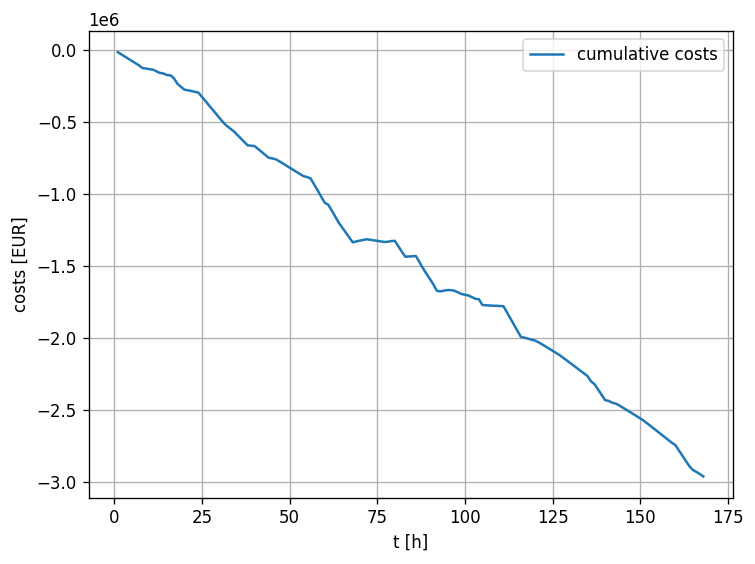

In [7]:
costs = (
    assets.asset_data['ngas_grid']['ngas_balance'] * assets.input_data['gas_price'] +
    assets.asset_data['electrical_grid']['power_balance'] * assets.input_data['power_price'] +
    assets.asset_data['hydrogen_grid']['hydrogen_balance'] * assets.input_data['gas_price'] * 5.0 -
    assets.asset_data['heat_grid']['heat_feedin'] * 100
)


plt.figure(dpi=120)
costs.cumsum().plot(label='cumulative costs')
plt.xlabel('t [h]')
plt.ylabel('costs [EUR]')
plt.grid()
plt.legend()
plt.tight_layout()

In [87]:
FONTSIZE = 12
LABELSIZE = 11

plt.rc('xtick', labelsize=LABELSIZE)
plt.rc('ytick', labelsize=LABELSIZE)

def plot_heat_storage():
    charge = assets.asset_data['heat_storage']['heat_charging']
    discharge = assets.asset_data['heat_storage']['heat_discharging'] * - 1
    content = assets.asset_data['heat_storage']['heat_content']
    x = range(1, len(charge) + 1)

    fig, axs = plt.subplots(nrows=2, ncols=1, figsize=(17, 7.5), dpi=120)

    axs[0].fill_between(x, content, step='pre', alpha=0.5, label='content', color='gold')
    axs[0].plot(x, content, drawstyle='steps', color='gold')
    axs[1].fill_between(x, discharge, step='pre', alpha=0.5, label='discharge')
    axs[1].fill_between(x, charge, step='pre', alpha=0.5, label='charge')
    axs[1].plot(x, discharge, drawstyle='steps')
    axs[1].plot(x, charge, drawstyle='steps')

    axs[0].set_xlabel('time [h]', fontsize=FONTSIZE)
    axs[0].set_ylabel('heat [MWh]', fontsize=FONTSIZE)
    axs[1].set_xlabel('time [h]', fontsize=FONTSIZE)
    axs[1].set_ylabel('thermal power [MW]')

    axs[0].grid()
    axs[1].grid()

    handle_labels = [ax.get_legend_handles_labels() for ax in fig.axes]
    handles, labels = [sum(lists, []) for lists in zip(*handle_labels)]

    fig.legend(handles, labels, ncols=3, bbox_to_anchor=(0.99, 1.04))
    fig.tight_layout()


def plot_battery_storage():
    charge = assets.asset_data['battery_storage']['power_charging']
    discharge = assets.asset_data['battery_storage']['power_discharging'] * - 1
    content = assets.asset_data['battery_storage']['power_content']
    x = range(1, len(charge) + 1)

    fig, axs = plt.subplots(nrows=2, ncols=1, figsize=(17, 7.5), dpi=120)

    axs[0].fill_between(x, content, step='pre', alpha=0.5, label='content', color='gold')
    axs[0].plot(x, content, drawstyle='steps', color='gold')
    axs[1].fill_between(x, discharge, step='pre', alpha=0.5, label='discharge')
    axs[1].fill_between(x, charge, step='pre', alpha=0.5, label='charge')
    axs[1].plot(x, discharge, drawstyle='steps')
    axs[1].plot(x, charge, drawstyle='steps')

    axs[0].set_xlabel('time [h]', fontsize=FONTSIZE)
    axs[0].set_ylabel('electrical energy [MWh]', fontsize=FONTSIZE)
    axs[1].set_xlabel('time [h]', fontsize=FONTSIZE)
    axs[1].set_ylabel('power [MW]')

    axs[0].grid()
    axs[1].grid()

    handle_labels = [ax.get_legend_handles_labels() for ax in fig.axes]
    handles, labels = [sum(lists, []) for lists in zip(*handle_labels)]

    fig.legend(handles, labels, ncols=3, bbox_to_anchor=(0.99, 1.04))
    fig.tight_layout()

def plot_energy_balance():
    # Heat data
    chp_heat = assets.asset_data['chp']['heat']
    hp_heat = assets.asset_data['heatpump']['heat']
    out_heat = assets.asset_data['heat_storage']['heat_discharging']
    in_heat = -assets.asset_data['heat_storage']['heat_charging']
    demand_heat = (assets.asset_data['heat_grid']['heat_feedin']
                   - assets.asset_data['heat_grid']['heat_supply'])
    # Power data
    chp_power = assets.asset_data['chp']['power']
    hp_power = -assets.asset_data['heatpump']['power']
    out_power = assets.asset_data['battery_storage']['power_discharging']
    in_power = -assets.asset_data['battery_storage']['power_charging']
    electrolyzer_power = -assets.asset_data['electrolyzer']['power']
    pv_power = assets.asset_data['pv']['power']
    balance_power = -assets.asset_data['electrical_grid']['power_balance']
    
    # Hydrogen data
    chp_hydrogen = -assets.asset_data['chp']['hydrogen']
    electrolyzer_hydrogen = assets.asset_data['electrolyzer']['hydrogen']
    balance_hydrogen = -assets.asset_data['hydrogen_grid']['hydrogen_balance']
    
    x = np.arange(len(chp_heat)) + 1
    
    fig, axs = plt.subplots(nrows=3, ncols=1, dpi=120, figsize=(17, 7.5))
    axs[0].fill_between(x, 
                        chp_heat,
                        step='pre',
                        color='C1',
                        alpha=0.5,
                        label='chp')
    axs[0].fill_between(x,
                        chp_heat, 
                        chp_heat + hp_heat, 
                        step='pre', 
                        color='C3', 
                        alpha=0.5, 
                        label='hp')
    axs[0].fill_between(x,
                        chp_heat + hp_heat,
                        chp_heat + hp_heat + out_heat,
                        step='pre',
                        color='C4',
                        alpha=0.5,
                        label='discharge')
    axs[0].fill_between(x, 
                        in_heat,
                        step='pre',
                        color='C2',
                        alpha=0.5,
                        label='charge')
    axs[0].plot(demand_heat, drawstyle='steps', color='dimgrey', label='demand')
    
    axs[0].set_ylabel('thermal power [MW]')
    axs[0].set_xlabel('time [h]')
    axs[0].grid()
    
    axs[1].fill_between(x, 
                        chp_power, 
                        step='pre',
                        color='C1', 
                        alpha=0.5)
    axs[1].fill_between(x,
                        chp_power,
                        chp_power + pv_power,
                        step='pre',
                        color='C8',
                        alpha=0.5,
                        label='pv')
    axs[1].fill_between(x,
                        electrolyzer_power,
                        step='pre',
                        color='C0',
                        alpha=0.5,
                        label='electrolyzer')
    axs[1].fill_between(x,
                        electrolyzer_power, 
                        electrolyzer_power + hp_power, 
                        step='pre',
                        color='C3', 
                        alpha=0.5)
    axs[1].fill_between(x, 
                        chp_power + pv_power, 
                        chp_power + pv_power + out_power, 
                        step='pre', 
                        color='C4',
                        alpha=0.5)
    axs[1].fill_between(x, 
                        electrolyzer_power + hp_power, 
                        electrolyzer_power + hp_power + in_power, 
                        step='pre', 
                        color='C2',
                        alpha=0.5)
    axs[1].plot(balance_power, 
                drawstyle='steps', 
                color='dimgrey', 
                label='balance')
    
    axs[1].set_ylabel('electrical power [MW]')
    axs[1].set_xlabel('time [h]')
    axs[1].grid()
    
    axs[2].fill_between(x, 
                        chp_hydrogen, 
                        step='pre', 
                        color='C1',
                        alpha=0.5)
    axs[2].fill_between(x, 
                        electrolyzer_hydrogen, 
                        step='pre', 
                        color='C0', 
                        alpha=0.5)
    axs[2].plot(balance_hydrogen, 
                drawstyle='steps', 
                color='dimgrey')
    
    axs[2].set_ylabel('hydrogen [MWh/h]')
    axs[2].set_xlabel('time [h]')
    axs[2].grid()
    
    fig.legend(ncols=8, bbox_to_anchor=(0.99, 1.04))
    fig.tight_layout()

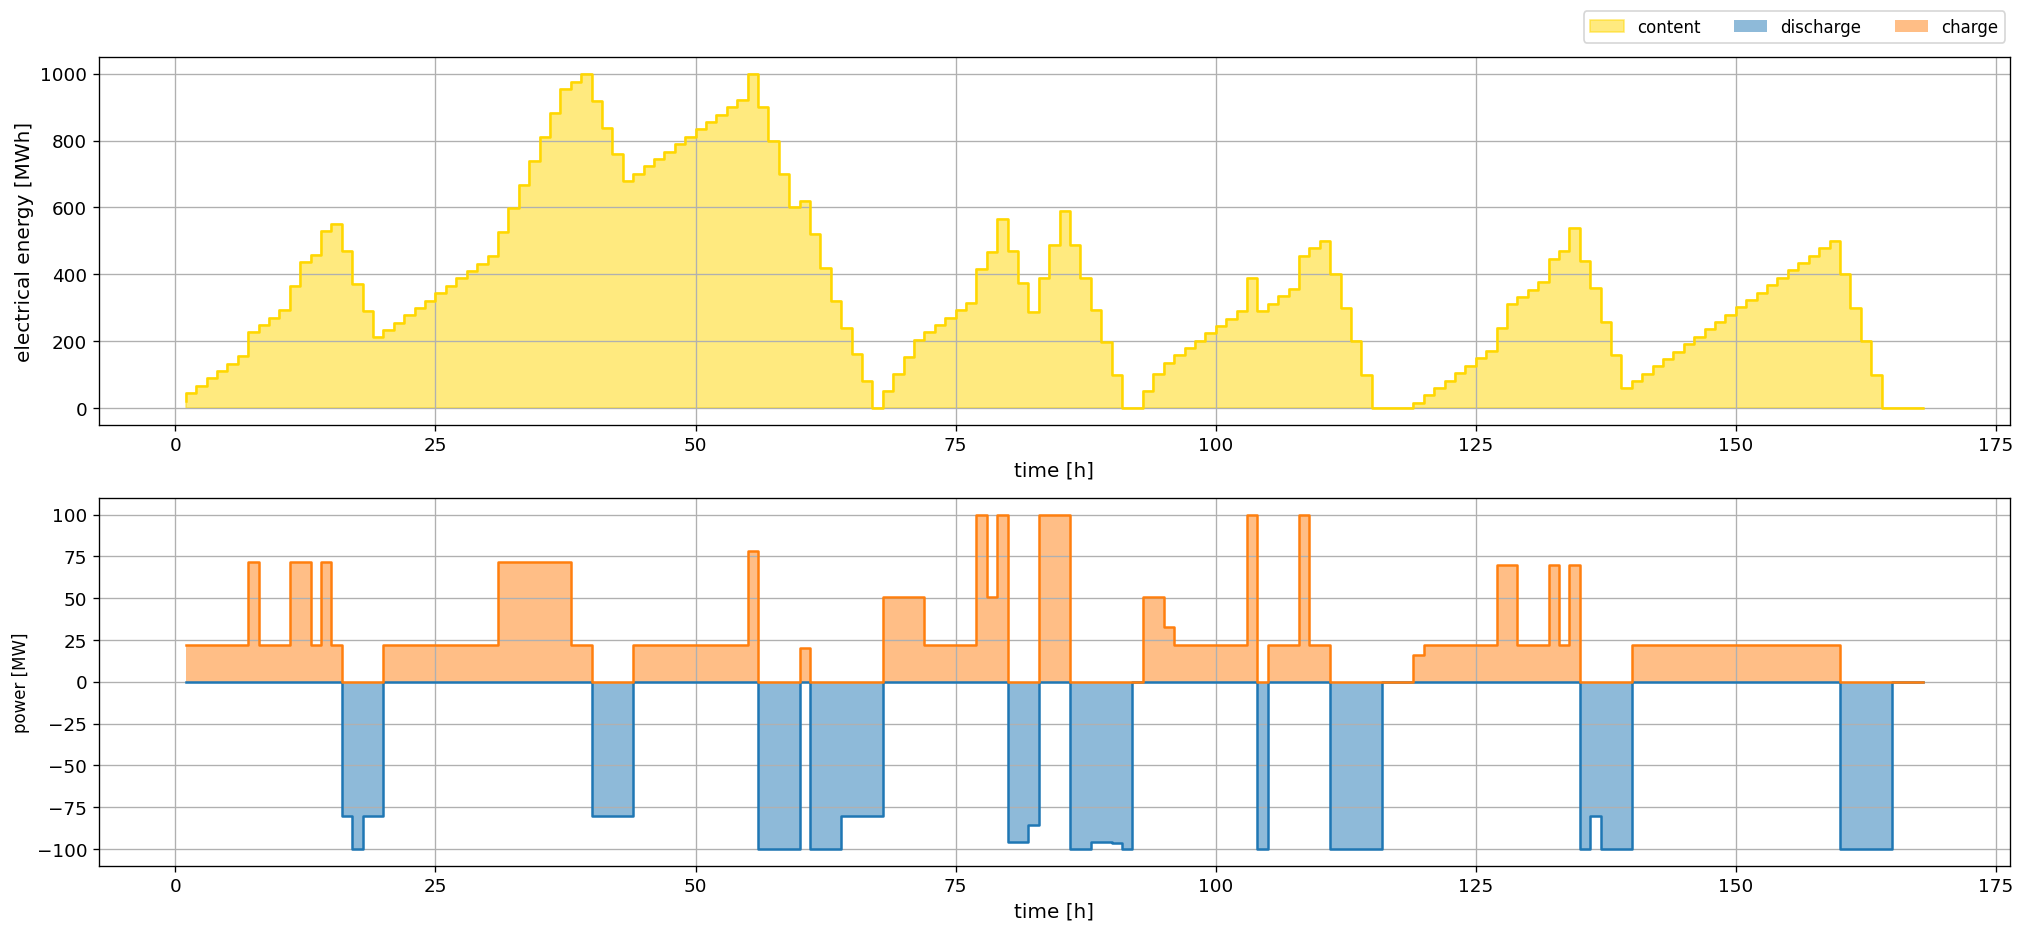

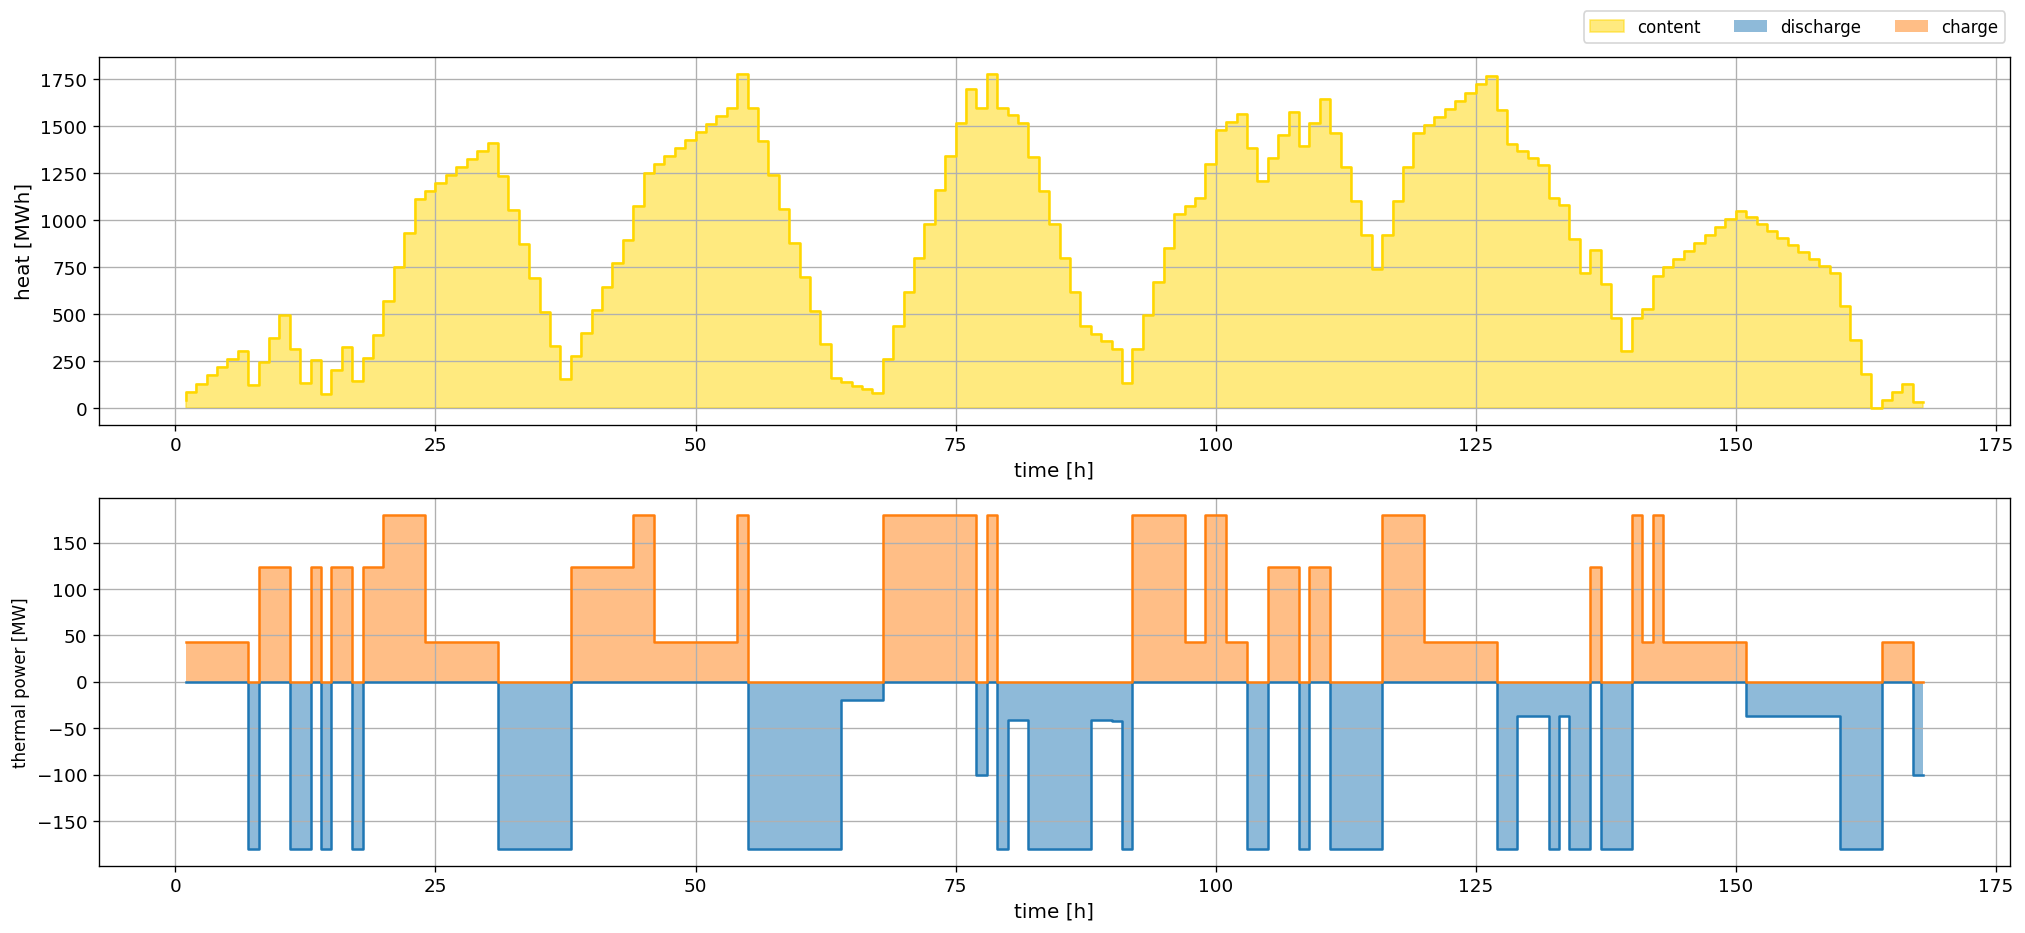

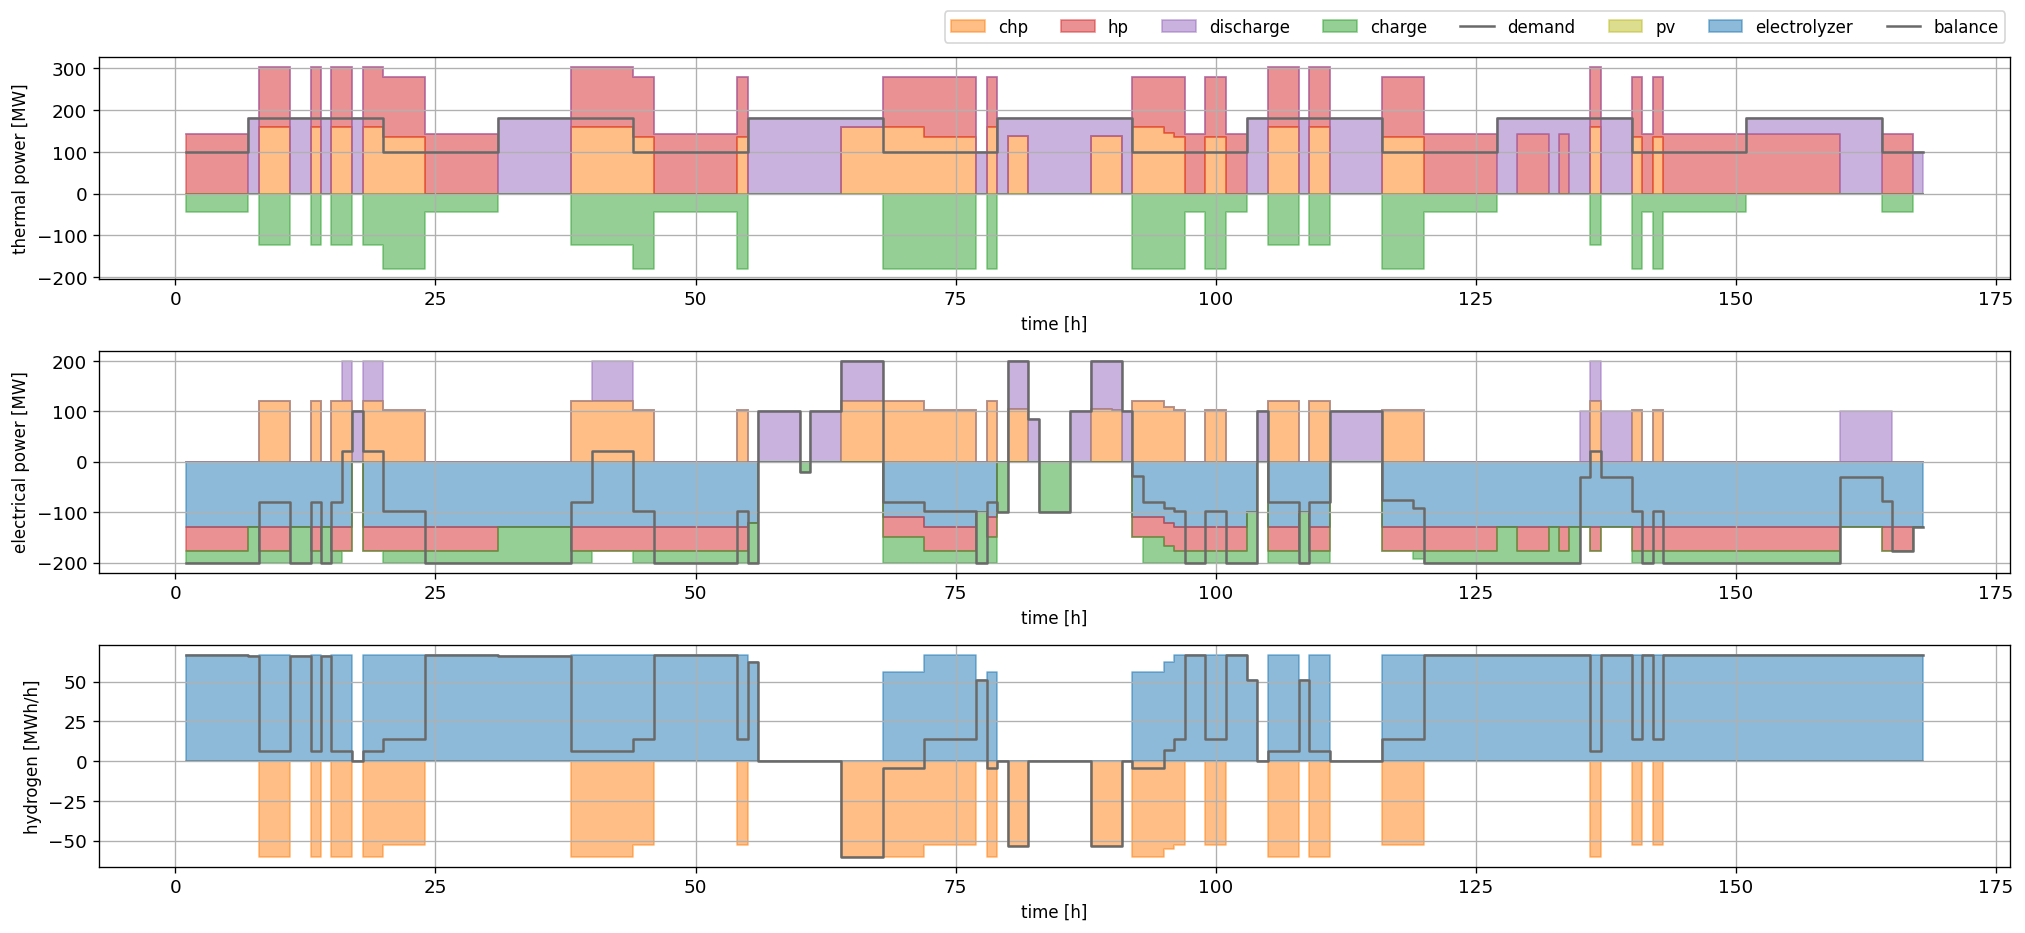

In [88]:
plot_battery_storage()
plot_heat_storage()
plot_energy_balance()